In [406]:
# Core imports 
from copy import deepcopy
import importlib
import warnings

# Installed imports 
import matplotlib.pyplot as plt
import numpy as np

# Local imports
import Driving
from Driving import NavigationDemoLogParser, FrameParsers, driveUtilities
from Driving.NavigationDemoLogParser import NavigationDemoLogParser
import src.learning.training_utils
import src.utils.data_loading
import src.utils.data_processing
import src.utils.experiment_utils
import src.utils.visualization

importlib.reload(src.utils.data_loading)
importlib.reload(src.utils.data_processing)
importlib.reload(src.learning.training_utils)
importlib.reload(src.utils.experiment_utils)
importlib.reload(src.utils.visualization)

from src.learning.training_utils import *
from src.utils.data_loading import *
from src.utils.data_processing import *
from src.utils.experiment_utils import * 
from src.utils.visualization import *

Set parameters

In [407]:
seconds_per_TR = 2.0045 # generally to have around 
seconds_per_sample = 1/15

# Data parameters 
k_closest_vehicles = 7
k_closest_pedestrians = 0

params = Params(k_closest_vehicles, k_closest_pedestrians, None, None, None, seconds_per_sample)

Start by loading the demonstrations

In [408]:
# Load the full demonstrations 
train_demonstrations = load_demonstrations_file(f"./Data/Demonstrations/train_demonstrations_k_closest_vehicles={k_closest_vehicles}_k_closest_pedestrians={k_closest_pedestrians}.npz")
validation_demonstrations = load_demonstrations_file(f"./Data/Demonstrations/validation_demonstrations_k_closest_vehicles={k_closest_vehicles}_k_closest_pedestrians={k_closest_pedestrians}.npz")
test_demonstrations = load_demonstrations_file(f"./Data/Demonstrations/test_demonstrations_k_closest_vehicles={k_closest_vehicles}_k_closest_pedestrians={k_closest_pedestrians}.npz")
centerlines = load_centerlines("./Data/LogAndLabelData/map_centerlines.npz")

In [409]:
 # Pull out just the states, make the centerline direction adjustments, then convert to line frame
 train_demonstration_states_world_frame = [fix_centerline_direction(demonstration[0], k_closest_vehicles, k_closest_pedestrians) for demonstration in train_demonstrations]
 validation_demonstration_states_world_frame = [fix_centerline_direction(demonstration[0], k_closest_vehicles, k_closest_pedestrians) for demonstration in validation_demonstrations]

 train_demonstration_states_line_frame = [line_frame(demonstration_states, k_closest_vehicles, k_closest_pedestrians) for demonstration_states in train_demonstration_states_world_frame]
 validation_demonstration_states_line_frame = [line_frame(demonstration_states, k_closest_vehicles, k_closest_pedestrians) for demonstration_states in validation_demonstration_states_world_frame]

##### Define the IDM controller 

In [410]:
def idm_controller_update_line_frame(state, dt, params):
    """ 
        https://en.wikipedia.org/wiki/Intelligent_driver_model
        Map from a current state to a next 
        ego vehicle state (x, y, angle, speed)
    """
    # Pull out the ego vehicle state
    x, y, angle, speed = state[0:4]
    v_y = speed * np.sin(angle)

    # Consider the vehicle as facing up or down depending on the angle 
    upwards = True if np.sin(angle) > 0 else False

    # Find the closest vehicle y position in the appropriate direction 
    # relative to the ego vehicle
    closest_vehicle_y = np.inf if upwards else -np.inf
    closest_vehicle_v_y = speed

    centerline_index = centerline_col(params.k_closest_vehicles, params.k_closest_pedestrians)
    centerline_x = state[centerline_index]
    
    for vehicle_index in range(params.k_closest_vehicles):
        vehicle_col = vehicle_index_to_col(vehicle_index)
        vehicle_x, vehicle_y, vehicle_angle, vehicle_speed = state[vehicle_col:vehicle_col+4]
        vehicle_v_y = vehicle_speed * np.sin(vehicle_angle)

        # Check that it's on the same side of the centerline as us 
        if np.sign(vehicle_x - centerline_x) == np.sign(x - centerline_x):
            if upwards and  vehicle_y > y and vehicle_y < closest_vehicle_y:
                closest_vehicle_y = vehicle_y
                closest_vehicle_v_y = vehicle_v_y
            elif not upwards and vehicle_y < y and vehicle_y > closest_vehicle_y:
                closest_vehicle_y = vehicle_y
                closest_vehicle_v_y = vehicle_v_y

    if not upwards:
        # Flip everything upside down to compute 
        y = -y
        v_y = -v_y
        closest_vehicle_y = -closest_vehicle_y
        closest_vehicle_v_y = -closest_vehicle_v_y

    # Compute the velocity and acceleration based on the 
    # distance to the closest vehicle. 
    # v_0, s_0, T, a, b, and l are all parameters of the IDM
    v_0 = 1118 # centimeters per second, 35mph is 1565, 25mph is 1118
    s_0 = 500 # centimeters, desired minimum distance between vehicles
    T = 1.6 # seconds, desired time headway 
    a = 671 # maximum vehicle acceleration, 60mph/2.3seconds = 1166 cm/s/s... maybe slow it down to 60mph/4 seconds? 671
    b = 500 # comfortable braking deceleration
    l = 470 # centimeters 
    delta = 4 # exponent in the IDM equation, typically set to 4

    # Compute approaching rate and s_star 
    approaching_rate = v_y - closest_vehicle_v_y
    s_star = s_0 + v_y * T + v_y * approaching_rate / (2 * np.sqrt(a * b))

    # Compute the change in speed and acceleration
    s = closest_vehicle_y - y - l
    if s < 0:
        warnings.warn("s < 0, crashed")
        s = s_star/5 # what to do here instead?

    y_dot = v_y 
    v_y_dot = a * (1 - (v_y/v_0)**delta - (s_star/s)**2)

    # Compute the new state
    new_x = x
    new_y = y + y_dot * dt
    new_angle = np.pi/2
    new_v_y = v_y + v_y_dot * dt

    print("new v y before flip: ", new_v_y)

    # If was downwards, flip things back
    if not upwards:
        new_y = -new_y
        new_v_y = -new_v_y
        new_angle = -np.pi/2

        new_speed = -new_v_y # since facing down, speed is in direction of heading, so will be flipped sign from it 

    return np.array([new_x, new_y, new_angle, new_speed])

    # # Calculating the approaching rate and s* from these parameters 
    # approaching_rate = v_y - closest_vehicle_v_y if upwards else closest_vehicle_v_y - v_y
    # if upwards:
    #     s_star = s_0 + v_y * T  + v_y * approaching_rate / (2 * np.sqrt(a * b))
    # else:
    #     s_star = s_0 - v_y * T - v_y * approaching_rate / (2 * np.sqrt(a * b))

    # # Now actually computing the change in speed and acceleration
    # s = closest_vehicle_y - y if upwards else y - closest_vehicle_y  
    # s = s - l
    # # Throw a warning if s < 0 
    # if s < 0:
    #     warnings.warn("s < 0, crashed")
    #     s = s_star/5 # set it to something small to avoid dividing by 0

    # # TODO: will we need to flip the sign based on going up or dow？
    # y_dot = v_y
    # if upwards:
    #     v_y_dot = a * (1 - (v_y/v_0)**delta - (s_star/s)**2)
    # else: 
    #     v_y_dot = -a * (1 - (v_y/(-v_0))**delta - (s_star/s)**2)

    # print("s: ", s)
    # print("s star: ", s_star)
    # print("v y dot: ", v_y_dot)

    # new_x = x
    # new_y = y + y_dot * dt
    # #new_angle = np.arctan2(new_y - y, new_x - x)
    # new_angle = np.pi/2 if upwards else -np.pi/2

    # new_v_y = v_y + v_y_dot * dt

    # new_speed = new_v_y if upwards else -new_v_y

    # print("speed: ", speed)
    # print("new speed: ", new_speed)

    # return np.array([new_x, new_y, new_angle, new_speed])



Rollout for a given demonstration

In [411]:
original_states = deepcopy(train_demonstration_states_line_frame[0][70:, :])
rollout_states = rollout_controller_line_frame(original_states, idm_controller_update_line_frame, params)


new v y before flip:  320.33810708541046
new v y before flip:  283.71051431343705
new v y before flip:  254.43090312352226
new v y before flip:  230.52718572274043
new v y before flip:  210.5256837472067
new v y before flip:  193.50809401169846
new v y before flip:  178.91813217302126
new v y before flip:  166.21380525495348
new v y before flip:  155.02739168164686
new v y before flip:  145.07811326580972
new v y before flip:  136.14870882920312
new v y before flip:  128.06921755699963
new v y before flip:  120.70544937832476
new v y before flip:  113.95060232011828
new v y before flip:  107.71905323321558
new v y before flip:  101.97805215115307
new v y before flip:  96.60484967927701
new v y before flip:  91.58173661024394
new v y before flip:  86.87129926398606
new v y before flip:  82.44245444012373
new v y before flip:  78.2691696059248
new v y before flip:  74.32945465815314
new v y before flip:  70.60456547352662
new v y before flip:  67.07837351019961
new v y before flip:  63.7

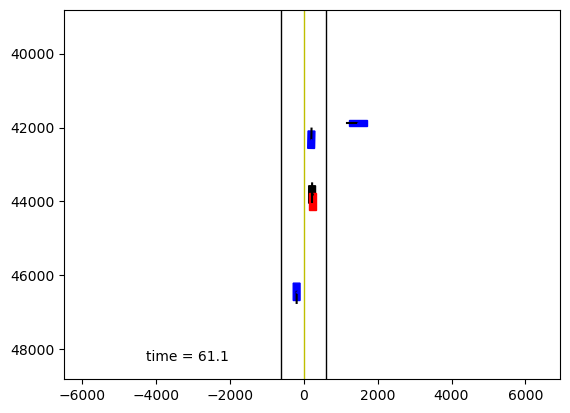

In [412]:
animate_trajectory(original_states, rollout_states, None, [0], params.k_closest_vehicles, params.k_closest_pedestrians, percent_to_animate=1.0, render_speedup=8.0, subsample=7, export_as_gif=False, export_as_mp4=False, filename="./Output/animation")


(115.76000000000167, 239.83999999999688, 42236.79, 71776.41)

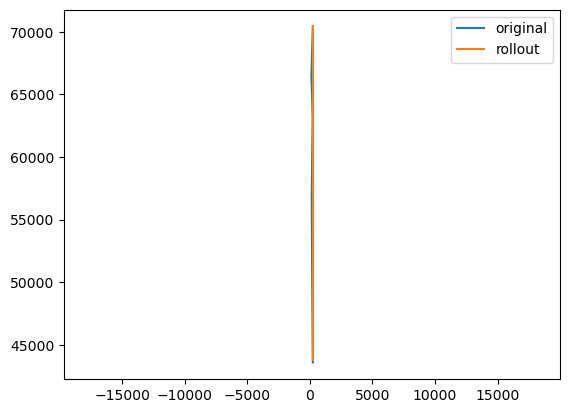

In [413]:
# plot xs, ys of original and new
plt.plot(original_states[:, 0], original_states[:, 1], label='original')
plt.plot(rollout_states[:, 0], rollout_states[:, 1], label='rollout')
plt.legend()
plt.axis('equal')

In [414]:
# params = Params(1, 0, None, None, None, seconds_per_sample=seconds_per_sample)
# state = np.array([0, 0, -np.pi/2, 0, 
#                   0, -1000, -np.pi/2, 100])

# update_one = idm_controller_update_line_frame(state, 0.1, params)

# state_two = deepcopy(state)
# state_two[0:4] = update_one

# update_two = idm_controller_update_line_frame(state_two, 0.1, params)
# print(update_one)
# print(update_two)